In [2]:
import pandas as pd
import sys, os
import binotools as bt
from binotools import calbino

import numpy as np
import pylab as plt
import reionizer
import astropy.io.fits as fits

plt.style.use('seaborn-talk')
from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

plt.rc('figure', dpi=150, figsize=(5,5))

# Depth

Get priority 3 (empty) slits

In [3]:
# Load slit csv file (output from Binomask)
slits = pd.read_csv(os.environ['BINO_DIR']+'2649_BLAS_1/masks/BLAS_1_slits.csv')
print(slits.shape)

# fits file ext # = slits.index + 1
slits['extnum'] = slits.index + 1

print(len(slits[slits.priority == 3.]))
# slits[slits.priority == 3.]

(174, 15)
44


# Load combined data

In [35]:
datadir = os.environ['BINO_DIR']+'SAO-9/combined_fluxcalib/combine_47_frames_seeing<1.00arcsec_2019-11-07/'
datadir = os.environ['BINO_DIR']+'SAO-9/combined_fluxcalib/combine_47_frames_seeing<1.00arcsec_tellcorr_2019-12-13/'

slits_data_file = datadir+"combined_fluxcalib_abs_slits_lin.fits"
err_data_file   = datadir+"combined_fluxcalib_abs_err_slits_lin.fits"

# Igor
# datadir      = os.environ['BINO_DIR']+'SAO-9/combined_fluxcalib/combine_47_frames_seeing<1.00arcsec_2019-11-05/'
# slits_data_file      = datadir+'obj_clean000_abs_slits_lin_fluxcalib.fits'

In [36]:
bino_plot     = bt.BinoPlotter(slits_data_file)
bino_plot_err = bt.BinoPlotter(err_data_file)

In [37]:
ypos_all = bt.get_ypos_from_2Dslits(slits_data_file)

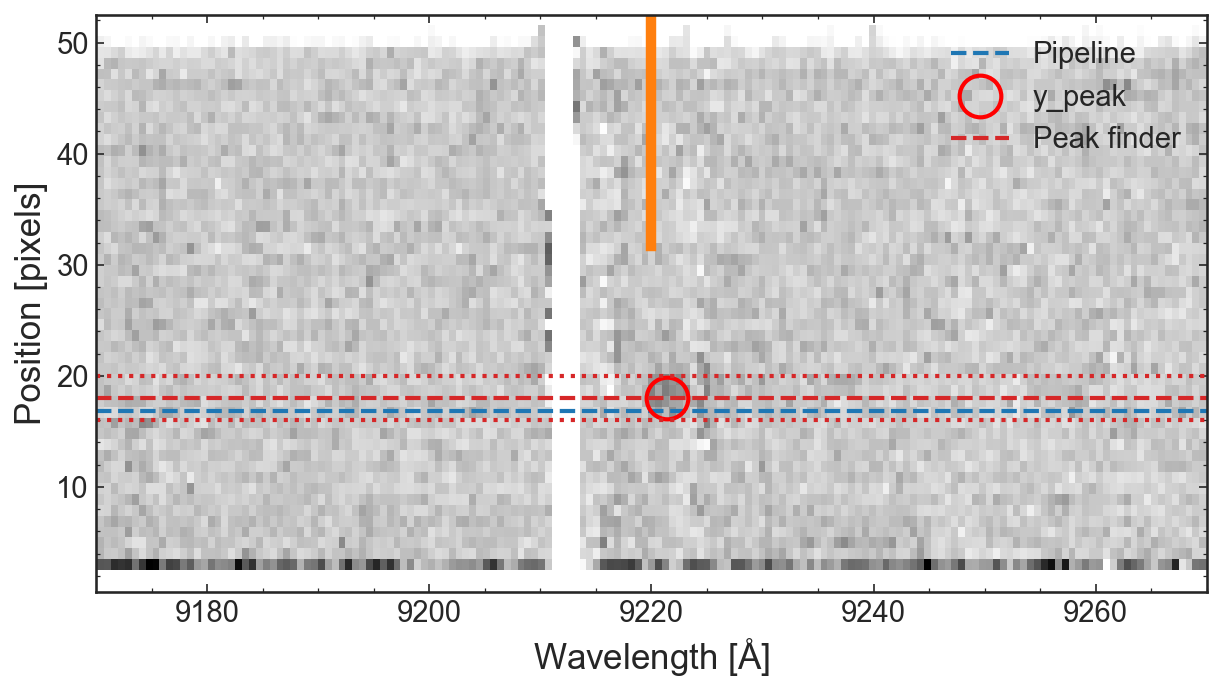

In [38]:
# Line to center on
Lya_wave   = 9220 #9188 #9220 #. # Wavelength to center on
posy_width = 4.    # Pixel width of extraction window for 1D spectrum (4 pix = PSF from stars ~1")
wave_limA  = 30.   # Wavelength range to plot over (Lya_wave /pm wave_limA)

targetid = 50 #50 #144 # slit number ( mask id + 1)

image, ypos = bino_plot.spec2D(target=targetid, wave_lineA=Lya_wave, posy_width=posy_width,
                               vmin_sig=-0.5, vmax_sig=2, wave_limA=50., posy=ypos_all[targetid-1],
                               smooth=None)

# Get pri 3 slits

44


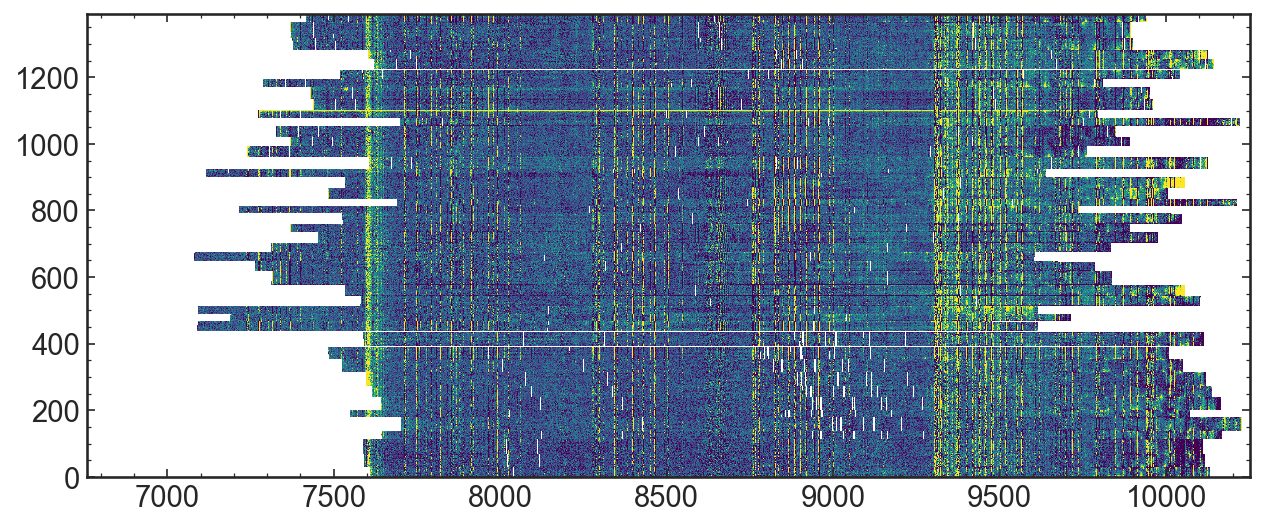

In [39]:
edge_pix = 3

slit3 = slits[slits.priority == 3.].reset_index()
print(len(slit3))

hdu_data = fits.open(slits_data_file)

dat2D_all = None
for i, slit in slit3.iterrows():
    dat2D = hdu_data[slit.extnum].data
        
    # exclude edges
    dat2D_noedge = dat2D[edge_pix:-edge_pix,:]
    
    if i == 0:
        dat2D_all = dat2D_noedge
    else:
        dat2D_all = np.vstack((dat2D_all, dat2D_noedge))

extent = [bino_plot.waveA.min(), bino_plot.waveA.max(),
          0.5, dat2D_all.shape[0]-0.5]
        
plt.figure(figsize=(10, 20), dpi=150)
plt.imshow(dat2D_all, extent=extent, vmin=0., vmax=5e-19)

## Clip bad pixels

-5.626579728604201e-19 9.351908198242983e-19
8.868866502925787e-20


/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


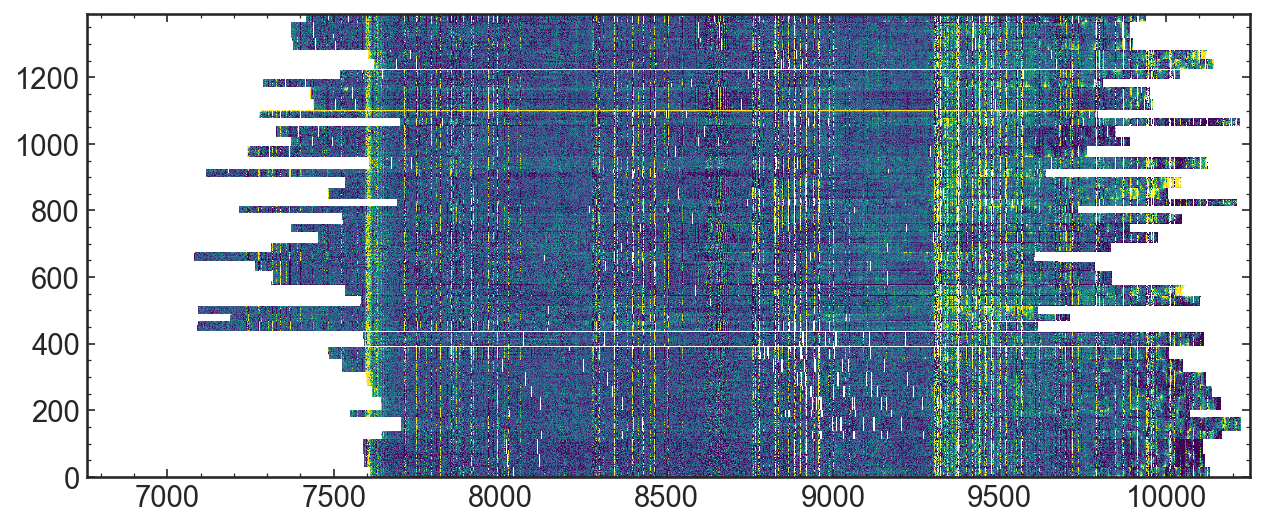

In [40]:
clip = 99.
flux_min, flux_max = np.nanpercentile(dat2D_all, 100-clip), np.nanpercentile(dat2D_all, clip)
print(flux_min, flux_max)

dat2D_all_clip = dat2D_all.copy()
dat2D_all_clip[np.where((dat2D_all_clip < flux_min) | (dat2D_all_clip > flux_max))] = np.nan

std1D   = np.nanstd(dat2D_all_clip, axis=0)
med_std = np.nanmedian(std1D)

print(med_std)

plt.figure(figsize=(10, 10), dpi=150)
plt.imshow(dat2D_all_clip, extent=extent,  vmin=0., vmax=5e-19)

### Telluric correction

In [41]:
calib_dir = os.environ['BINO_DIR']+'2649_BLAS_1/calib/'
trans     = np.genfromtxt(calib_dir+'BLAS_2019A_transmission.txt', names=True)

tellcorr = bt.TelluricCorrection()
dat2D_all_tellcorr = np.array([tellcorr.optimized_tellcorr(bino_plot.waveA, dat1D) for dat1D in dat2D_all_clip])

std1D   = np.nanstd(dat2D_all_clip, axis=0)
med_std = np.nanmedian(std1D) 

std1D_tellcorr   = np.nanstd(dat2D_all_tellcorr, axis=0)
med_std_tellcorr = np.nanmedian(std1D_tellcorr)

print(med_std), print(med_std_tellcorr)

8.868866502925787e-20
9.330349065565171e-20


(None, None)

## Flux limit

In [42]:
# Flux limit setup
PSF_pix = 4    # PSF in pixels
pixel_A = 0.61 # bino resolution 1 pixel = A angstrom

line_wave = 9000. # A
FWHM_kms  = 200.  # Linewidth in km/s
FWHM_A    = FWHM_kms/3e5 * line_wave
print(FWHM_A)
FWHM_pix  = FWHM_A/pixel_A # linewidth in pixels

# Calculate flux limit
flim = np.sqrt(2*FWHM_pix)*pixel_A * np.sqrt(2*PSF_pix) * std1D #std1D_tellcorr
print(np.nanmedian(flim))

6.0
6.786856268417557e-19


Text(0, 0.5, '1$\\sigma$ depth [erg/s/cm$^2$/A]\n 200 km/s line @ 9000A')

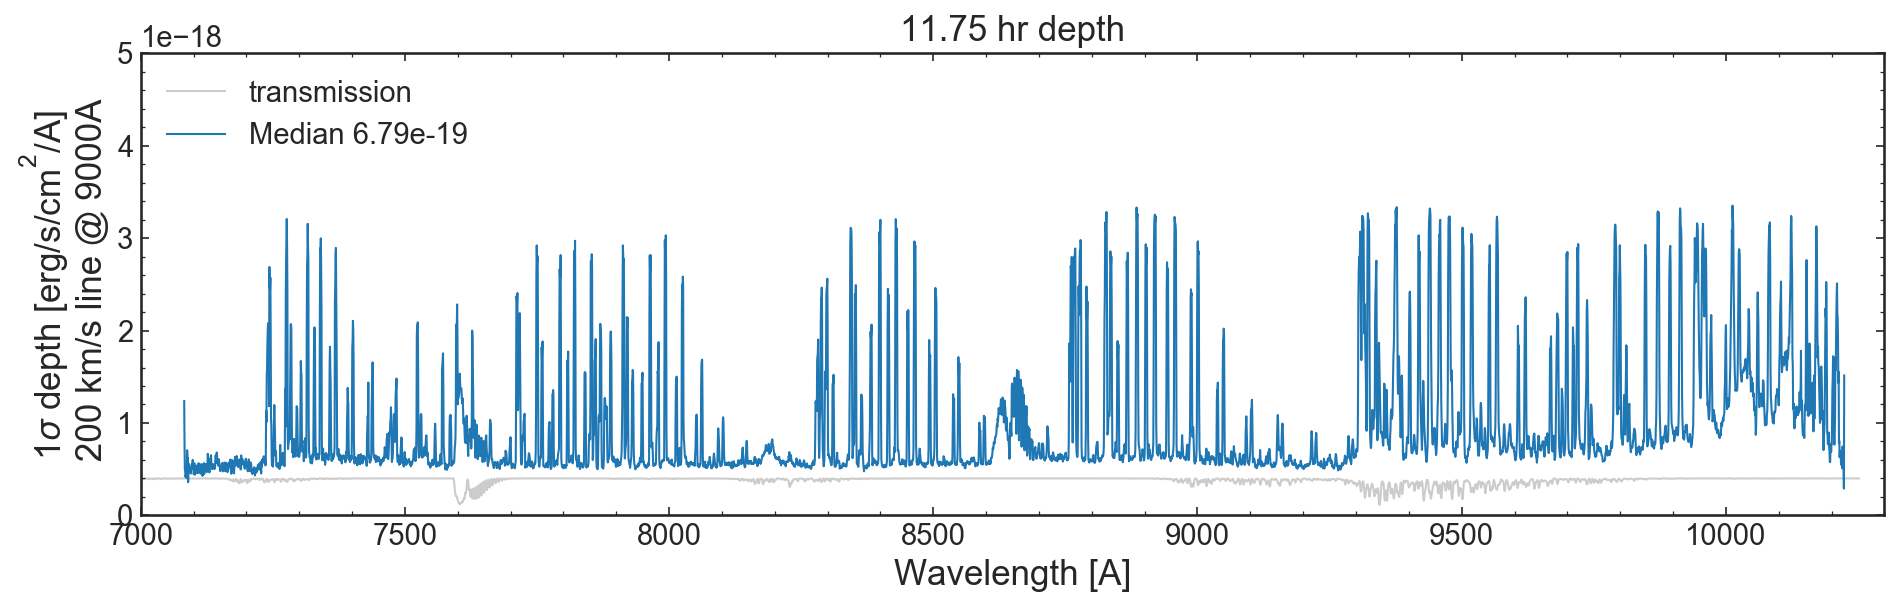

In [43]:
exptime_hrs = hdu_data[1].header['EXPTIME']/3600.

plt.figure(figsize=(15, 4), dpi=150)

plt.title('%.2f hr depth' % exptime_hrs)

plt.plot(10*trans['wave_nm'], trans['transmission']*0.4e-18, c='0.8', lw=1, zorder=0, label='transmission')

plt.plot(bino_plot.waveA, flim, lw=1, label='Median %.2e' % np.nanmedian(flim))

# plt.plot(bino_plot.waveA, std1D, lw=1)
# plt.plot(bino_plot.waveA, std1D_tellcorr, lw=1)

# plt.axhline(med_std)
# plt.axhline(med_std_tellcorr)

plt.ylim(0., 5e-18)
plt.xlim(7000, 10300)
# plt.xlim(8500, 8800)

plt.legend(loc='upper left', frameon=False)

plt.xlabel('Wavelength [A]')
plt.ylabel('1$\sigma$ depth [erg/s/cm$^2$/A]\n %.0f km/s line @ %.0fA' % (FWHM_kms, line_wave))

# Check star calibration

In [18]:
# Init flux cal
fluxcal = calbino.FluxCalBino()

stars = slits[slits.type == 'STANDARD']

# Find star mags
mags_all = []
for i in range(len(stars)):
    fluxcal.get_star_mags(stars.iloc[i].ra, stars.iloc[i].dec, verbose=False)
    star_mags = fluxcal.star_mags
    mags_all.append(star_mags)
    
stars['mags'] = mags_all
stars

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,slit,targetnum,name,ra,dec,pmra,pmdec,mag,priority,epoch,type,wave_start,wave_end,side,extnum,mags
19,255,1916,f_3,188.910191,62.352588,0,0,0.001,1,2000,STANDARD,6855.558347,9378.533932,A,20,"[16.74763, 16.47305, 16.38649]"
20,254,1915,f_2,188.902346,62.363999,0,0,0.001,1,2000,STANDARD,6773.112436,9296.124509,A,21,"[17.78395, 17.48049, 17.35731]"


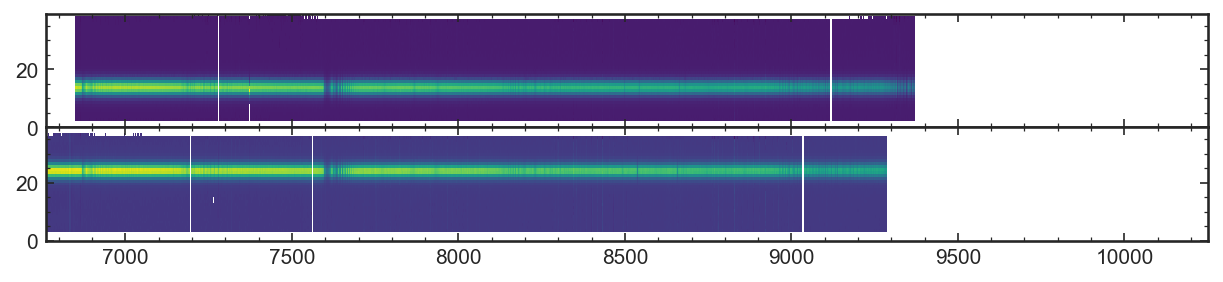

In [19]:
spec2D_hdu = fits.open(slits_data_file)

fig, ax = plt.subplots(2,1, figsize=(10,2), dpi=150, sharex=True)
# vmin, vmax = -10, 10

for i in range(2):
    spec2D_star = spec2D_hdu[stars.index[i]+1].data

    ax[i].imshow(spec2D_star, #vmin=vmin, vmax=vmax, 
                 aspect='auto',
                   extent=[bino_plot.waveA.min(), bino_plot.waveA.max(), 0., spec2D_star.shape[0]])

fig.subplots_adjust(hspace=0.)

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/Binotools-0.1.0-py3.7.egg/binotools/extract_spectra.py:36: RuntimeWarning: invalid value encountered in greater
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
No handles with labels found to put in legend.


Text(0, 0.5, 'Calibration')

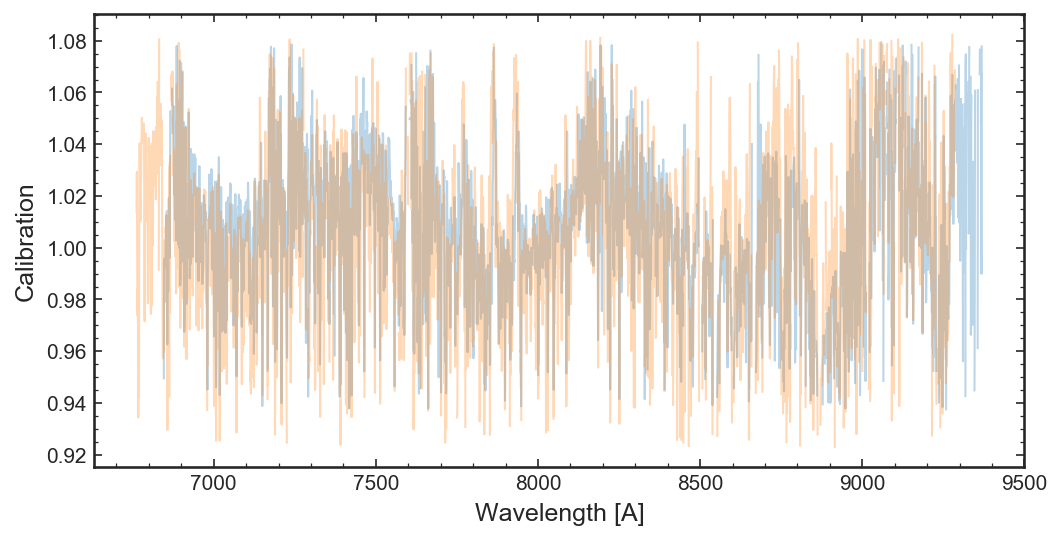

In [55]:
tellcorr = bt.TelluricCorrection(plot=False)

cut_badpix = 95.

# Frame ID
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=150)

# Each star
polyfitted_calibration_allstars = np.zeros((len(stars),len(bino_plot.waveA)))
for i in range(len(stars)):
    fluxcal.star_mags = stars.iloc[i]['mags']
    
    spec2D_star = spec2D_hdu[stars.index[i]+1].data
    
    # Get 1D spectrum
    spec1D_star_eachframe, FWHM_pix = bt.extract1D_psf(spec2D_star, psf_lim=0.02, plot_psf=False, ax=None)
    spec1D_star_eachframe[spec1D_star_eachframe == 0.] = np.nan
    
    # Do telluric correction
    spec1D_star_eachframe = tellcorr.optimized_tellcorr(bino_plot.waveA, spec1D_star_eachframe)

    # Calibration
    calibration = fluxcal.flux_calibration(spec1D_star_eachframe, bino_plot.waveA)

    # Filter bad pixels
    low, high = np.nanpercentile(calibration, 100-cut_badpix), np.nanpercentile(calibration, cut_badpix)
    calibration[np.where((calibration < low) | (calibration > high))] = np.nan
    
    # Smooth calibration
    polyfitted_calibration_allstars[i] = fluxcal.smooth_calibration(bino_plot.waveA, calibration, degree=2)

    # Plot
    ln = ax.plot(bino_plot.waveA, calibration, lw=1, alpha=0.3)
#     ax.plot(bino_plot.waveA, polyfitted_calibration_allstars[i], c=ln[0].get_color(), lw=2, alpha=1, label='star: %i' % (stars.iloc[i]['extnum']))
    
polyfitted_calibration_median = np.nanmedian(polyfitted_calibration_allstars, axis=0)
# plt.plot(bino_plot.waveA, polyfitted_calibration_median, label='median')

# ax.set_ylim(-0., 5e-18)

ax.legend(loc='lower left', ncol=2, frameon=True)
ax.set_xlabel('Wavelength [A]')
ax.set_ylabel('Calibration')